# Análisis Exploratorio de Datos para Modelos Avanzados

Este notebook realiza un análisis exhaustivo de las características disponibles para identificar:
1. Distribuciones de variables
2. Correlaciones con la demanda
3. Multicolinealidad entre variables
4. Outliers y anomalías
5. Importancia de características
6. Selección de features óptimas

El objetivo es preparar el mejor conjunto de características para los modelos avanzados.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import json

warnings.filterwarnings('ignore')

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]

## Configuración de Rango de Fechas

Define el rango de fechas para separar datos de entrenamiento y validación.

**Nota**: Este valor puede ser sobrescrito por el Notebook 00 (Pipeline Maestro) cuando se ejecuta automáticamente.

In [2]:
# PARÁMETROS - Esta celda puede ser sobrescrita por papermill (NB00)
# Si ejecutas este notebook manualmente, modifica estos valores aquí
# Si lo ejecutas desde NB00, estos valores serán reemplazados automáticamente

# Configuración de fecha de corte para separación train/validation
# Esta fecha define dónde termina el entrenamiento y empieza la validación
FECHA_CORTE_TRAIN_VAL = pd.Timestamp('2025-09-21 00:00:00')

In [3]:
# Mostrar configuración activa
print("="*80)
print("CONFIGURACIÓN DE FECHAS ACTIVA (NB03 - Exploratory Analysis)")
print("="*80)
print(f"Fecha de corte Train/Validation: {FECHA_CORTE_TRAIN_VAL}")
print(f"  • Entrenamiento: datos < {FECHA_CORTE_TRAIN_VAL}")
print(f"  • Validación:    datos >= {FECHA_CORTE_TRAIN_VAL}")
print("="*80)

CONFIGURACIÓN DE FECHAS ACTIVA (NB03 - Exploratory Analysis)
Fecha de corte Train/Validation: 2025-09-21 00:00:00
  • Entrenamiento: datos < 2025-09-21 00:00:00
  • Validación:    datos >= 2025-09-21 00:00:00


## Carga de Datos

## Preparación de Datos de Entrenamiento y Validación

In [4]:
# Cargar los datos completos
df = pd.read_parquet('artifacts/data/features/features_complete.parquet')

# Crear directorios para entrenamiento y validación
import os
os.makedirs('artifacts/data/train_models', exist_ok=True)
os.makedirs('artifacts/data/validation_models', exist_ok=True)

# Crear dataset de entrenamiento (datos anteriores a la fecha de corte)
df_train = df[df['datetime'] < FECHA_CORTE_TRAIN_VAL].copy()
df_train.to_parquet('artifacts/data/train_models/features_train.parquet')

# Crear dataset de validación (datos desde la fecha de corte en adelante)
df_val = df[df['datetime'] >= FECHA_CORTE_TRAIN_VAL].copy()
df_val.to_parquet('artifacts/data/validation_models/features_validation.parquet')

print(f"Datos completos:")
print(f"  Dimensiones: {df.shape}")
print(f"  Período: {df['datetime'].min()} a {df['datetime'].max()}")

print(f"\nDatos de entrenamiento:")
print(f"  Dimensiones: {df_train.shape}")
print(f"  Período: {df_train['datetime'].min()} a {df_train['datetime'].max()}")

print(f"\nDatos de validación:")
print(f"  Dimensiones: {df_val.shape}")
print(f"  Período: {df_val['datetime'].min()} a {df_val['datetime'].max()}")

print(f"\n✓ Archivos guardados:")
print(f"  - artifacts/data/train_models/features_train.parquet")
print(f"  - artifacts/data/validation_models/features_validation.parquet")

Datos completos:
  Dimensiones: (24600, 33)
  Período: 2023-01-01 00:00:00 a 2025-10-21 23:00:00

Datos de entrenamiento:
  Dimensiones: (23856, 33)
  Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00

Datos de validación:
  Dimensiones: (744, 33)
  Período: 2025-09-21 00:00:00 a 2025-10-21 23:00:00

✓ Archivos guardados:
  - artifacts/data/train_models/features_train.parquet
  - artifacts/data/validation_models/features_validation.parquet


## Análisis Exploratorio sobre Datos de Entrenamiento

In [5]:
# Verificar los datos de entrenamiento
print(f"Dataset de entrenamiento:")
print(f"  Dimensiones: {df_train.shape}")
print(f"  Período: {df_train['datetime'].min()} a {df_train['datetime'].max()}")
print(f"  Variables: {df_train.shape[1]}")

# Información básica
display(df_train.head())
print("\nTipos de datos:")
print(df_train.dtypes)

Dataset de entrenamiento:
  Dimensiones: (23856, 33)
  Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00
  Variables: 33


,datetime,demanda,hora_del_dia_sin,hora_del_dia_cos,dia_semana_sin,dia_semana_cos,mes_sin,mes_cos,hora_del_dia,dia_semana,mes,trimestre,año,es_festivo,es_finde,es_laboral,es_hora_pico_mañana,es_hora_pico_tarde,lag_1h,lag_24h,lag_48h,lag_168h,media_movil_6h,std_movil_6h,media_movil_12h,std_movil_12h,media_movil_24h,std_movil_24h,media_movil_48h,std_movil_48h,media_movil_168h,std_movil_168h,price
0,2023-01-01 00:00:00,21419.667,0.000,1.000,-0.782,0.623,0.500,0.866,0,6,1,1,2023,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.450
1,2023-01-01 01:00:00,20627.083,0.259,0.966,-0.782,0.623,0.500,0.866,1,6,1,1,2023,0,1,0,0,0,21419.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.010
2,2023-01-01 02:00:00,19437.083,0.500,0.866,-0.782,0.623,0.500,0.866,2,6,1,1,2023,0,1,0,0,0,20627.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.070
3,2023-01-01 03:00:00,18331.750,0.707,0.707,-0.782,0.623,0.500,0.866,3,6,1,1,2023,0,1,0,0,0,19437.083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.690
4,2023-01-01 04:00:00,17712.167,0.866,0.500,-0.782,0.623,0.500,0.866,4,6,1,1,2023,0,1,0,0,0,18331.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.910



Tipos de datos:
datetime               datetime64[ns]
demanda                       float64
hora_del_dia_sin              float64
hora_del_dia_cos              float64
dia_semana_sin                float64
dia_semana_cos                float64
mes_sin                       float64
mes_cos                       float64
hora_del_dia                    int32
dia_semana                      int32
mes                             int32
trimestre                       int32
año                             int32
es_festivo                      int64
es_finde                        int64
es_laboral                      int64
es_hora_pico_mañana             int64
es_hora_pico_tarde              int64
lag_1h                        float64
lag_24h                       float64
lag_48h                       float64
lag_168h                      float64
media_movil_6h                float64
std_movil_6h                  float64
media_movil_12h               float64
std_movil_12h                 flo

## Análisis de Variables Numéricas

In [6]:
# Excluir columna datetime y temporada para análisis numérico
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Estadísticas descriptivas
print("Estadísticas descriptivas de las variables numéricas:")
stats_df = df_train[numeric_cols].describe().T
stats_df['missing'] = df_train[numeric_cols].isnull().sum()
stats_df['missing_pct'] = (stats_df['missing'] / len(df_train) * 100).round(2)
display(stats_df)

Estadísticas descriptivas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max,missing,missing_pct
demanda,23808.000,28372.970,4510.060,17325.917,24662.292,28391.167,31704.375,42126.000,48,0.200
hora_del_dia_sin,23856.000,-0.000,0.707,-1.000,-0.707,0.000,0.707,1.000,0,0.000
hora_del_dia_cos,23856.000,-0.000,0.707,-1.000,-0.707,-0.000,0.707,1.000,0,0.000
dia_semana_sin,23856.000,-0.000,0.707,-0.975,-0.782,0.000,0.782,0.975,0,0.000
dia_semana_cos,23856.000,-0.000,0.707,-0.901,-0.901,-0.223,0.623,1.000,0,0.000
mes_sin,23856.000,0.047,0.711,-1.000,-0.500,0.000,0.866,1.000,0,0.000
mes_cos,23856.000,-0.075,0.697,-1.000,-0.866,-0.000,0.500,1.000,0,0.000
hora_del_dia,23856.000,11.500,6.922,0.000,5.750,11.500,17.250,23.000,0,0.000
dia_semana,23856.000,3.000,2.000,0.000,1.000,3.000,5.000,6.000,0,0.000
mes,23856.000,6.082,3.308,1.000,3.000,6.000,9.000,12.000,0,0.000



Variables con valores faltantes: 15


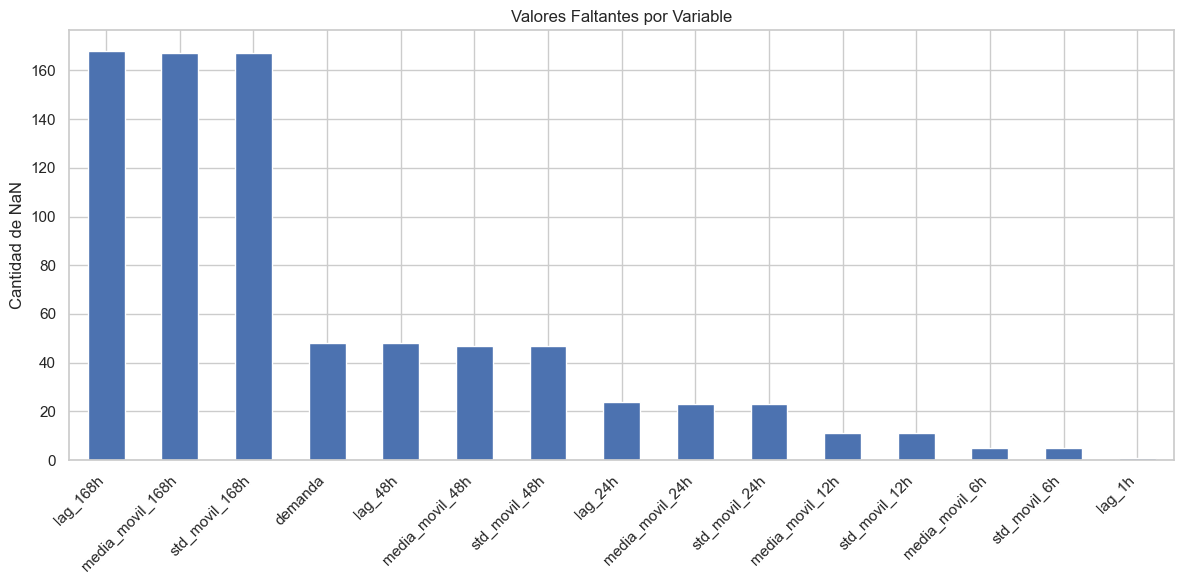

In [7]:
# Análisis de valores faltantes
missing_data = df_train[numeric_cols].isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print(f"\nVariables con valores faltantes: {len(missing_data)}")
    plt.figure(figsize=(12, 6))
    missing_data.plot(kind='bar')
    plt.title('Valores Faltantes por Variable')
    plt.ylabel('Cantidad de NaN')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No hay valores faltantes en las variables numéricas")

## Distribución de la Variable Objetivo (Demanda)

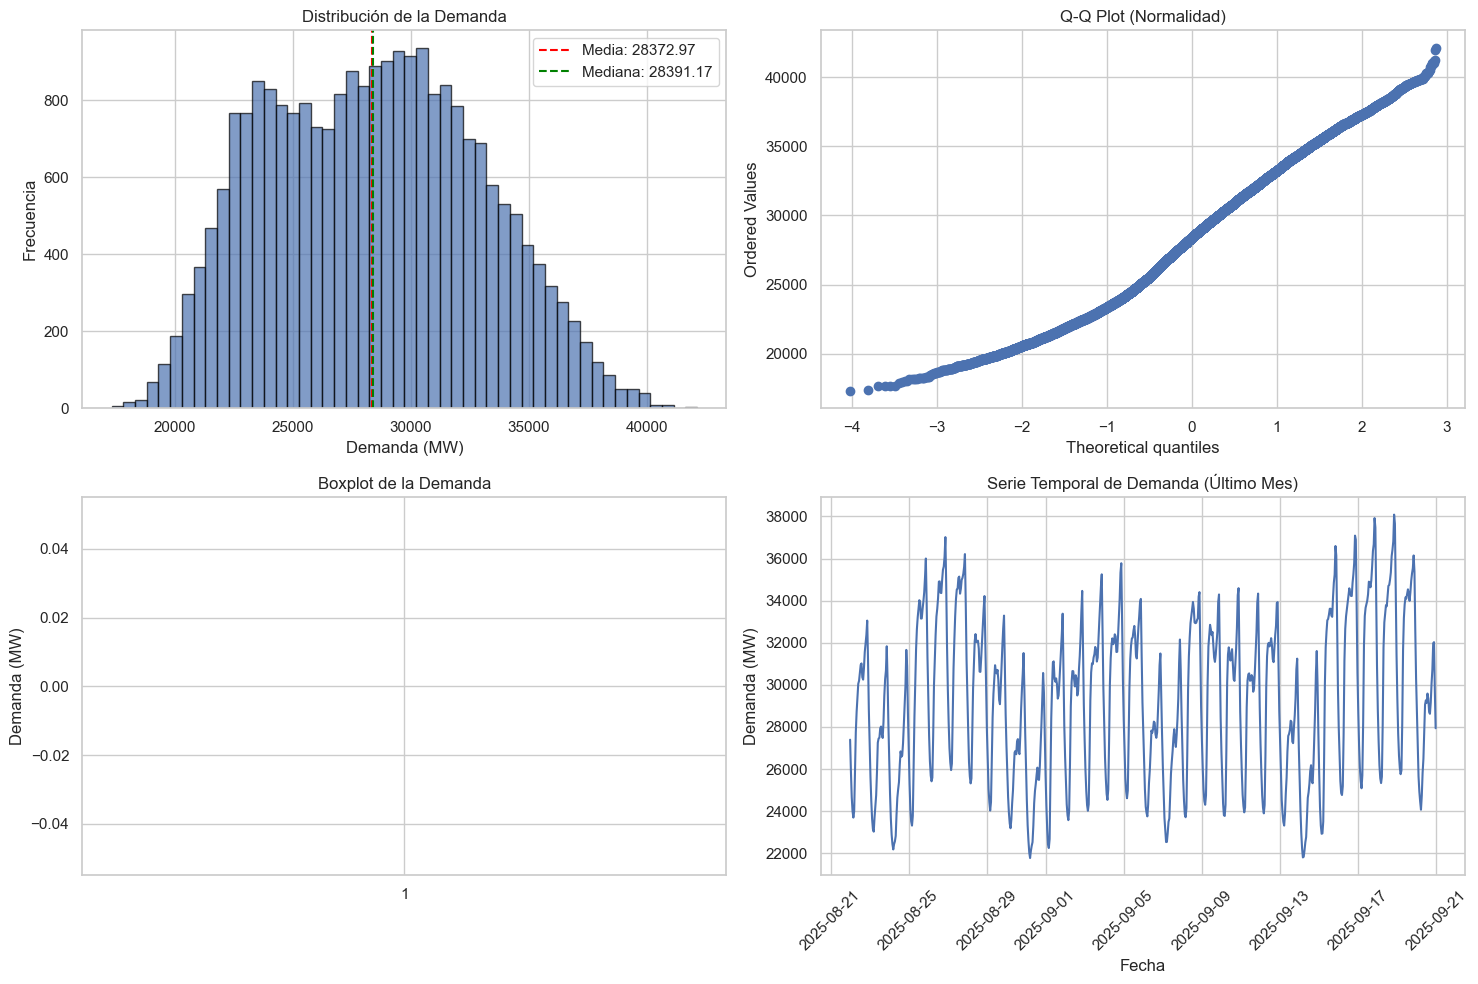

In [8]:
# Análisis de la demanda
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0, 0].hist(df_train['demanda'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_train['demanda'].mean(), color='red', linestyle='--', label=f'Media: {df_train["demanda"].mean():.2f}')
axes[0, 0].axvline(df_train['demanda'].median(), color='green', linestyle='--', label=f'Mediana: {df_train["demanda"].median():.2f}')
axes[0, 0].set_title('Distribución de la Demanda')
axes[0, 0].set_xlabel('Demanda (MW)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()

# Q-Q plot
stats.probplot(df_train['demanda'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normalidad)')

# Boxplot
axes[1, 0].boxplot(df_train['demanda'], vert=True)
axes[1, 0].set_title('Boxplot de la Demanda')
axes[1, 0].set_ylabel('Demanda (MW)')

# Serie temporal (muestra de 1 mes)
sample_period = df_train.tail(24*30)  
axes[1, 1].plot(sample_period['datetime'], sample_period['demanda'])
axes[1, 1].set_title('Serie Temporal de Demanda (Último Mes)')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].set_ylabel('Demanda (MW)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Matriz de Correlación

Top 20 variables más correlacionadas con la demanda:
demanda              1.000
lag_1h               0.953
lag_168h             0.897
lag_24h              0.817
media_movil_6h       0.810
lag_48h              0.638
media_movil_12h      0.609
media_movil_24h      0.603
hora_del_dia         0.553
price                0.541
media_movil_48h      0.510
std_movil_24h        0.462
media_movil_168h     0.438
es_laboral           0.398
std_movil_48h        0.366
dia_semana_sin       0.334
std_movil_168h       0.330
es_hora_pico_tarde   0.287
año                  0.110
mes_cos              0.062
Name: demanda, dtype: float64


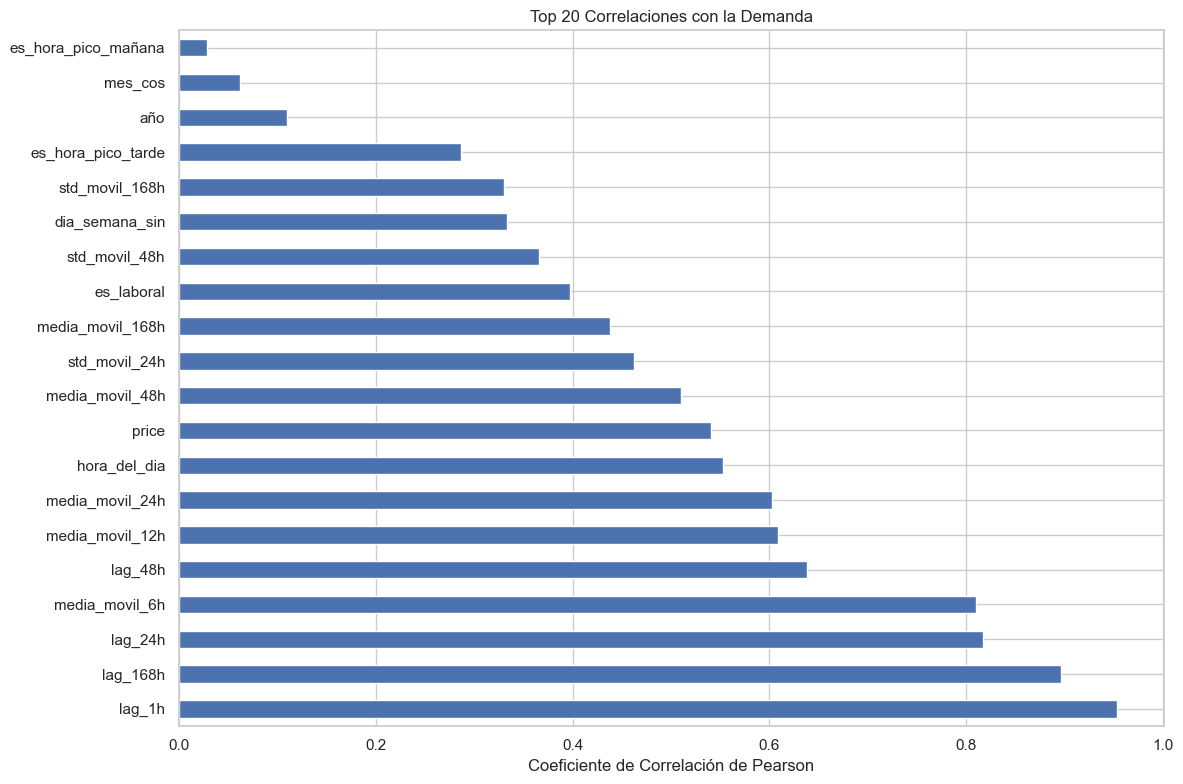

In [9]:
# Calcular matriz de correlación
correlation_matrix = df_train[numeric_cols].corr()

# Correlación con la demanda
corr_with_target = correlation_matrix['demanda'].sort_values(ascending=False)
print("Top 20 variables más correlacionadas con la demanda:")
print(corr_with_target.head(20))

# Visualizar correlaciones con la demanda
plt.figure(figsize=(12, 8))
corr_with_target[1:21].plot(kind='barh') 
plt.title('Top 20 Correlaciones con la Demanda')
plt.xlabel('Coeficiente de Correlación de Pearson')
plt.tight_layout()
plt.show()

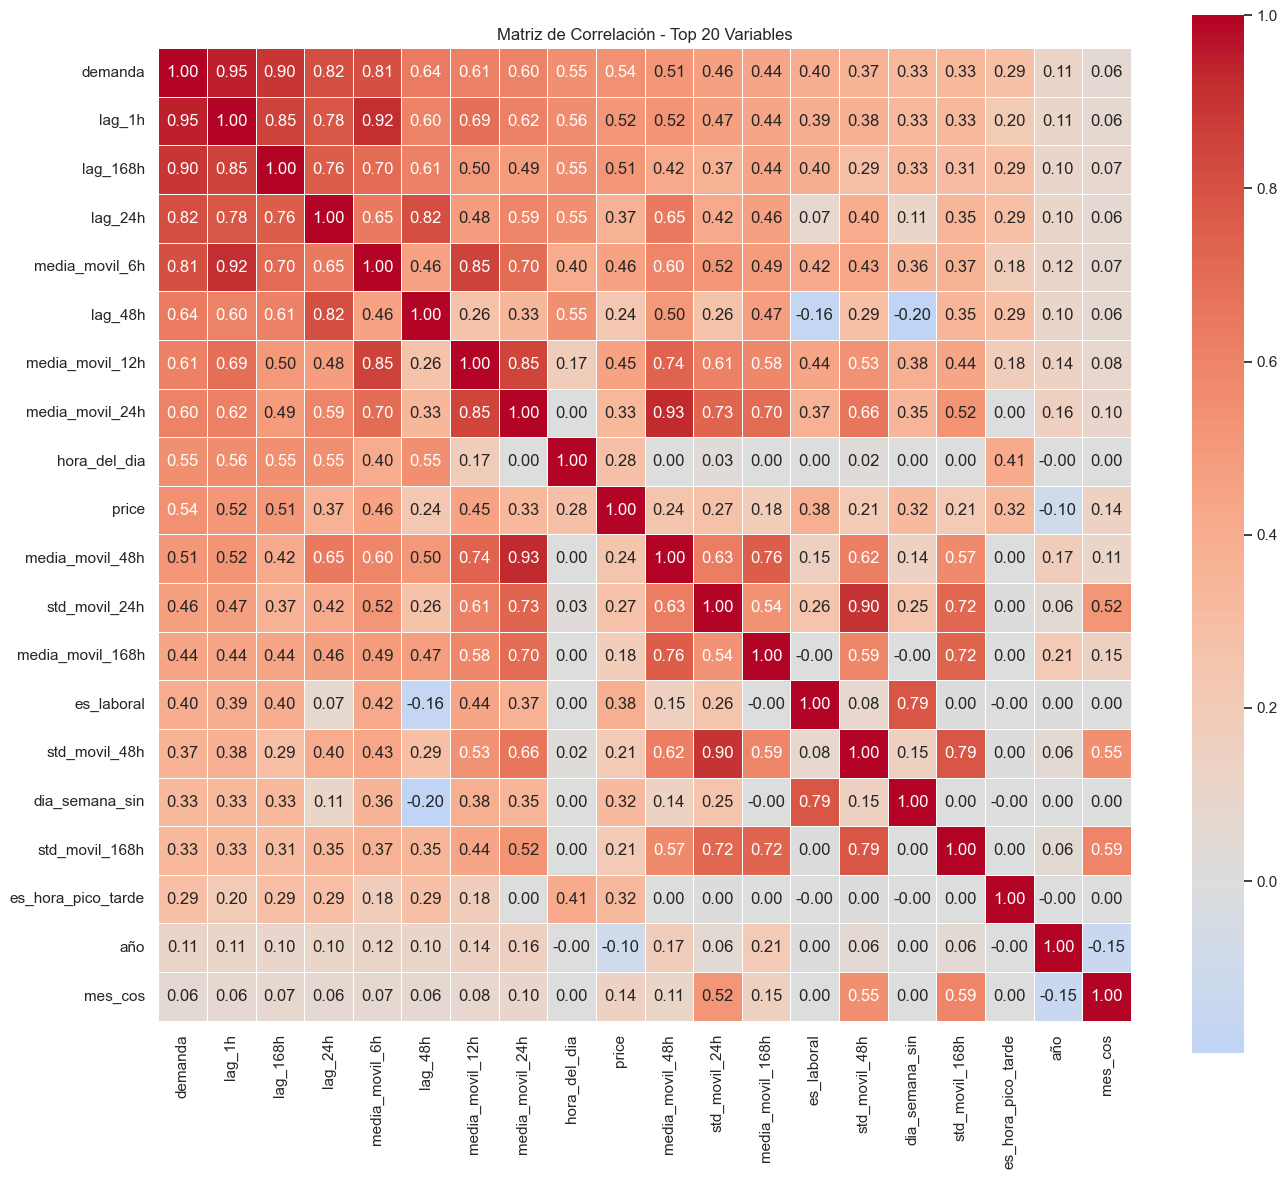

In [10]:
# Matriz de correlación completa (solo variables más relevantes)
top_vars = corr_with_target.head(20).index.tolist()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix.loc[top_vars, top_vars], 
            annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Top 20 Variables')
plt.tight_layout()
plt.show()

## Detección de Multicolinealidad

In [11]:
# Identificar pares de variables altamente correlacionadas
def find_high_correlations(corr_matrix, threshold=0.9):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'var1': corr_matrix.columns[i],
                    'var2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    return pd.DataFrame(high_corr_pairs)

high_corr = find_high_correlations(correlation_matrix, threshold=0.9)

if len(high_corr) > 0:
    print(f"\nPares de variables con correlación > 0.9: {len(high_corr)}")
    display(high_corr.sort_values('correlation', ascending=False, key=abs).head(20))
else:
    print("\n✓ No se detectaron pares de variables con correlación > 0.9")


Pares de variables con correlación > 0.9: 5


,var1,var2,correlation
2,es_finde,es_laboral,-1.000
1,mes,trimestre,0.969
0,demanda,lag_1h,0.953
4,media_movil_24h,media_movil_48h,0.928
3,lag_1h,media_movil_6h,0.916


## Análisis de Importancia de Características

Utilizaremos un Random Forest rápido para estimar la importancia de las características.

In [12]:
# Preparar datos (eliminar NaN y datetime)
df_clean = df_train[numeric_cols].dropna()
X = df_clean.drop('demanda', axis=1)
y = df_clean['demanda']

print(f"Datos para análisis de importancia:")
print(f"  Muestras: {len(X):,}")
print(f"  Features: {X.shape[1]}")

# Entrenar Random Forest rápido para obtener importancias
print("\nEntrenando Random Forest para análisis de importancia...")
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_split=100,
    n_jobs=-1,
    random_state=42
)
rf.fit(X, y)
print("✓ Modelo entrenado")

# Obtener importancias
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 características más importantes:")
display(feature_importance.head(30))

Datos para análisis de importancia:
  Muestras: 23,640
  Features: 31

Entrenando Random Forest para análisis de importancia...
✓ Modelo entrenado

Top 30 características más importantes:
✓ Modelo entrenado

Top 30 características más importantes:


,feature,importance
16,lag_1h,0.908
1,hora_del_dia_cos,0.033
19,lag_168h,0.031
6,hora_del_dia,0.006
14,es_hora_pico_mañana,0.005
17,lag_24h,0.004
0,hora_del_dia_sin,0.004
23,std_movil_12h,0.003
21,std_movil_6h,0.002
15,es_hora_pico_tarde,0.001


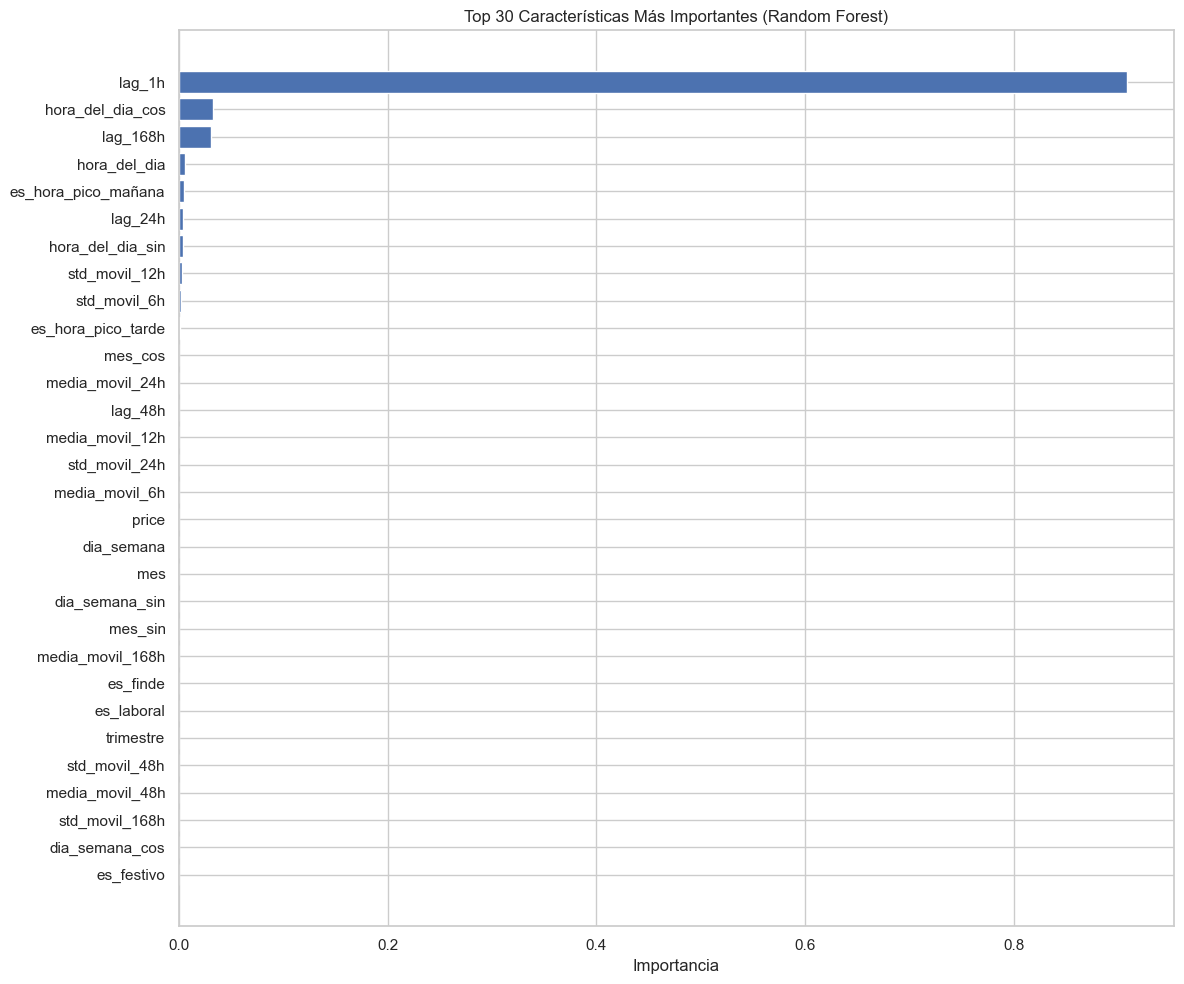

In [13]:
# Visualizar importancias
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 30 Características Más Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Información Mutua (Mutual Information)

Calculando información mutua...

Top 30 características por Información Mutua:

Top 30 características por Información Mutua:


,feature,mi_score
16,lag_1h,1.359
19,lag_168h,0.959
17,lag_24h,0.823
20,media_movil_6h,0.680
22,media_movil_12h,0.418
6,hora_del_dia,0.377
24,media_movil_24h,0.377
18,lag_48h,0.351
30,price,0.232
26,media_movil_48h,0.231


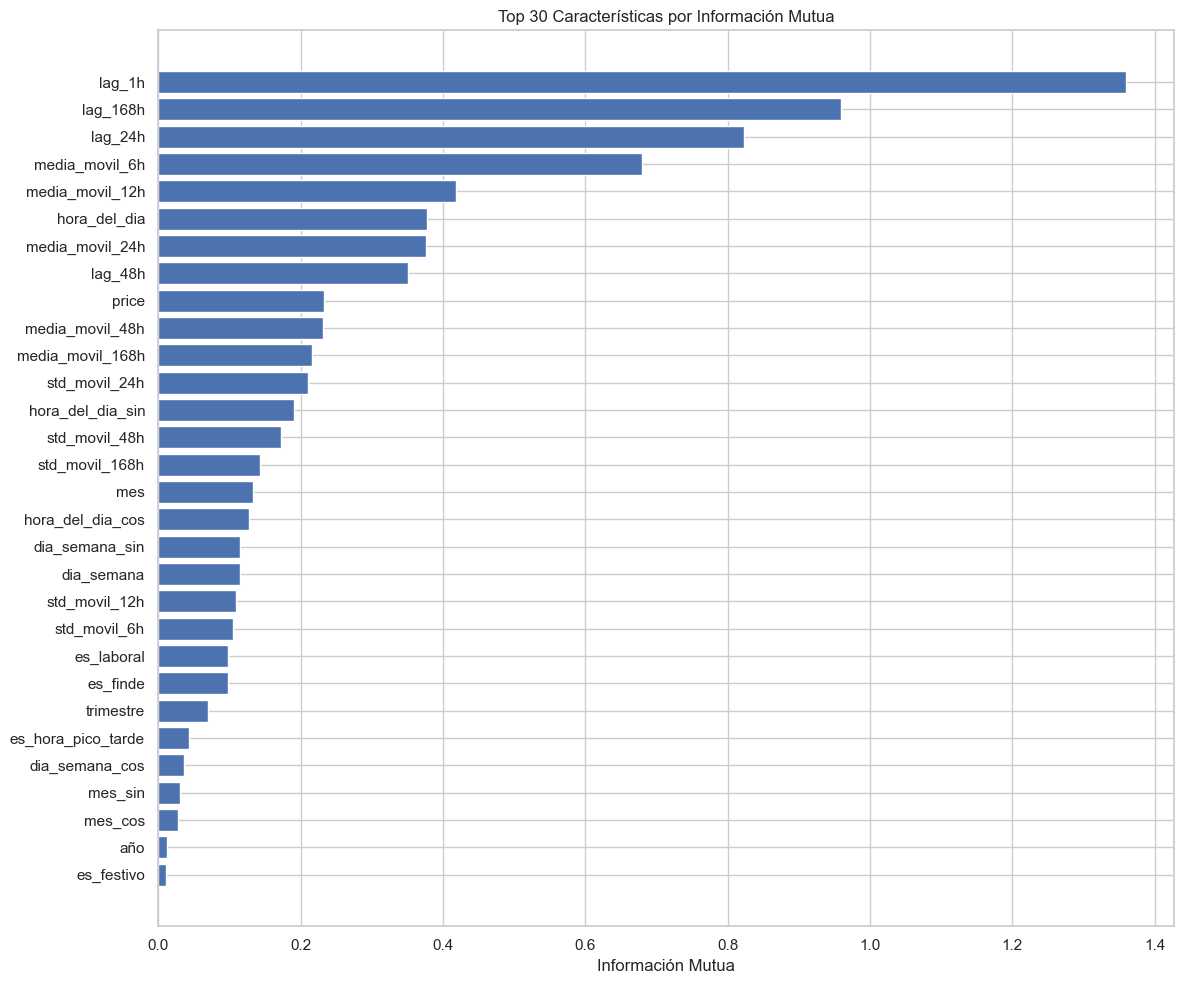

In [14]:
# Calcular información mutua
print("Calculando información mutua...")
mi_scores = mutual_info_regression(X, y, random_state=42, n_neighbors=5)

mi_importance = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 30 características por Información Mutua:")
display(mi_importance.head(30))

# Visualizar
plt.figure(figsize=(12, 10))
top_mi = mi_importance.head(30)
plt.barh(range(len(top_mi)), top_mi['mi_score'])
plt.yticks(range(len(top_mi)), top_mi['feature'])
plt.xlabel('Información Mutua')
plt.title('Top 30 Características por Información Mutua')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Selección de Features Óptimas

In [15]:
# Combinar rankings de importancia
# Normalizar scores para hacer comparables
feature_importance['rf_rank'] = range(1, len(feature_importance) + 1)
mi_importance['mi_rank'] = range(1, len(mi_importance) + 1)

# Merge
combined_importance = feature_importance.merge(
    mi_importance[['feature', 'mi_score', 'mi_rank']], 
    on='feature'
)

# Score combinado (menor es mejor para ranks)
combined_importance['combined_rank'] = (
    combined_importance['rf_rank'] + combined_importance['mi_rank']
) / 2

combined_importance = combined_importance.sort_values('combined_rank')

print("Top 40 características por ranking combinado:")
display(combined_importance.head(40))

Top 40 características por ranking combinado:


,feature,importance,rf_rank,mi_score,mi_rank,combined_rank
0,lag_1h,0.908,1,1.359,1,1.000
2,lag_168h,0.031,3,0.959,2,2.500
5,lag_24h,0.004,6,0.823,3,4.500
3,hora_del_dia,0.006,4,0.377,6,5.000
1,hora_del_dia_cos,0.033,2,0.128,17,9.500
13,media_movil_12h,0.000,14,0.418,5,9.500
11,media_movil_24h,0.000,12,0.377,7,9.500
15,media_movil_6h,0.000,16,0.680,4,10.000
6,hora_del_dia_sin,0.004,7,0.191,13,10.000
12,lag_48h,0.000,13,0.351,8,10.500


In [16]:
# Seleccionar top features evitando multicolinealidad
def select_features_avoiding_multicollinearity(importance_df, corr_matrix, n_features=50, corr_threshold=0.95):
    selected_features = []
    
    for _, row in importance_df.iterrows():
        feature = row['feature']
        
        # Verificar correlación con features ya seleccionadas
        if len(selected_features) == 0:
            selected_features.append(feature)
        else:
            # Calcular correlación máxima con features seleccionadas
            max_corr = 0
            for selected in selected_features:
                if feature in corr_matrix.columns and selected in corr_matrix.columns:
                    corr_val = abs(corr_matrix.loc[feature, selected])
                    max_corr = max(max_corr, corr_val)
            
            # Añadir si no está altamente correlacionada
            if max_corr < corr_threshold:
                selected_features.append(feature)
        
        if len(selected_features) >= n_features:
            break
    
    return selected_features

# Seleccionar top 50 features sin multicolinealidad
selected_features = select_features_avoiding_multicollinearity(
    combined_importance, 
    correlation_matrix, 
    n_features=50,
    corr_threshold=0.95
)

print(f"\nFeatures seleccionadas: {len(selected_features)}")
print("\nLista de features seleccionadas:")
for i, feat in enumerate(selected_features, 1):
    print(f"{i:2d}. {feat}")


Features seleccionadas: 29

Lista de features seleccionadas:
 1. lag_1h
 2. lag_168h
 3. lag_24h
 4. hora_del_dia
 5. hora_del_dia_cos
 6. media_movil_12h
 7. media_movil_24h
 8. media_movil_6h
 9. hora_del_dia_sin
10. lag_48h
11. price
12. std_movil_24h
13. std_movil_12h
14. std_movil_6h
15. media_movil_168h
16. es_hora_pico_tarde
17. mes
18. es_hora_pico_mañana
19. media_movil_48h
20. dia_semana
21. dia_semana_sin
22. mes_cos
23. std_movil_48h
24. std_movil_168h
25. es_finde
26. mes_sin
27. dia_semana_cos
28. es_festivo
29. año


## Guardar Resultados del Análisis

In [17]:
# Crear directorio para análisis si no existe
analysis_dir = Path('artifacts/analysis')
analysis_dir.mkdir(parents=True, exist_ok=True)

# Guardar features seleccionadas
with open(analysis_dir / 'selected_features.json', 'w') as f:
    json.dump({'features': selected_features}, f, indent=2)

print(f"✓ Features seleccionadas guardadas en {analysis_dir / 'selected_features.json'}")

# Guardar importancias combinadas
combined_importance.to_csv(analysis_dir / 'feature_importance.csv', index=False)
print(f"✓ Importancias guardadas en {analysis_dir / 'feature_importance.csv'}")

# Guardar correlaciones altas
if len(high_corr) > 0:
    high_corr.to_csv(analysis_dir / 'high_correlations.csv', index=False)
    print(f"✓ Correlaciones altas guardadas en {analysis_dir / 'high_correlations.csv'}")

# Guardar estadísticas descriptivas
stats_df.to_csv(analysis_dir / 'descriptive_stats.csv')
print(f"✓ Estadísticas descriptivas guardadas en {analysis_dir / 'descriptive_stats.csv'}")

print("\n" + "="*50)
print("ANÁLISIS EXPLORATORIO COMPLETADO")
print("="*50)
print(f"\nTotal de features originales: {len(numeric_cols) - 1}") 
print(f"Features seleccionadas: {len(selected_features)}")
print(f"Reducción: {(1 - len(selected_features)/(len(numeric_cols)-1))*100:.1f}%")

✓ Features seleccionadas guardadas en artifacts/analysis/selected_features.json
✓ Importancias guardadas en artifacts/analysis/feature_importance.csv
✓ Correlaciones altas guardadas en artifacts/analysis/high_correlations.csv
✓ Estadísticas descriptivas guardadas en artifacts/analysis/descriptive_stats.csv

ANÁLISIS EXPLORATORIO COMPLETADO

Total de features originales: 31
Features seleccionadas: 29
Reducción: 6.5%
✓ Correlaciones altas guardadas en artifacts/analysis/high_correlations.csv
✓ Estadísticas descriptivas guardadas en artifacts/analysis/descriptive_stats.csv

ANÁLISIS EXPLORATORIO COMPLETADO

Total de features originales: 31
Features seleccionadas: 29
Reducción: 6.5%
